# Prepare data for ml

Prepare all data sets in the format required for training and testing the ml models.
The annotated spatial transcriptomics (ST) data that I have access to consists of eight different data sets originating from eight tissue samples. Predictions will be made on a per-sample basis, while training is performed on a set of data from multiple samples. I will store data from 3 samples for testing, and the remaining samples will be used for training and validation.
  
***
For each data set, do:  

* Add sample information to annotation data and add binarized cancer labels  
* Join count matrix and annotation data into one AnnData object. 
* Filter features (genes) and observations (spots) based on expression cutoffs  
* Normalize and logarithmize data. 
  
Once each data set is prepared, merge them into one object in the format obs~feat.  

Split data into train (train+validation sets) and test set. Save each object as files.
***

Filtering and normalization of the data will be performed using the Scanpy module (https://scanpy-tutorials.readthedocs.io/en/latest/index.html)

## Set up

In [344]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, Union, List

from IPython.display import display

from inspect import getsourcefile
import glob
import os
import os.path as osp
import argparse as arp
import sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
import anndata as ad
from sklearn.preprocessing import MinMaxScaler

In [6]:
DIR = '/'.join(osp.realpath(getsourcefile(lambda: 0)).split('/')[:-2])
DIR_DATA = DIR + '/data/her2st'
print('', DIR, '\n', DIR_DATA)

path_data = DIR_DATA + '/ST-cnts'
path_spot = DIR_DATA + '/ST-spotfiles'
path_anno = DIR_DATA + '/ST-pat' + '/labels'
path_img = DIR_DATA + '/ST-imgs'

 /Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project 
 /Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st


In [379]:
sample_id = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G2', 'H1']

In [380]:
for path in [path_data, path_spot, path_anno, path_img]:
    for s in sample_id:
        #print (pth)
        print(glob.glob(path + '/*' + s + '*'))

['/Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st/ST-cnts/A1.tsv.gz']
['/Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st/ST-cnts/B1.tsv.gz']
['/Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st/ST-cnts/C1.tsv.gz']
['/Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st/ST-cnts/D1.tsv.gz']
['/Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st/ST-cnts/E1.tsv.gz']
['/Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st/ST-cnts/F1.tsv.gz']
['/Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st/ST-cnts/G2.tsv.gz']
['/Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st/ST-cnts/H1.tsv.gz']
['/Users/lovisa.franzen/Documents/Courses/ml_medbioinfo_2020/ml_project/data/her2st/ST-spotfiles/A1_selection.tsv']
['/Users/lovisa.franzen/Documents/Courses/ml_medbioi

## Functions

In [370]:
def ReadSTData(sample_id, path_data, path_spot, path_anno):

    # Read data objects
    data_df = pd.read_csv(glob.glob(path_data + '/*' + sample_id + '*')[0],
                          sep='\t',
                          header=0,
                          index_col=0)

    spots_df = pd.read_csv(glob.glob(path_spot + '/*' + sample_id + '*')[0],
                           sep='\t',
                           index_col=None)
    spots_df['sample_id'] = sample_id

    anno_df = pd.read_csv(glob.glob(path_anno + '/*' + sample_id + '*')[0],
                          sep='\t',
                          index_col=None)
    
    # Remove rows with NaN from annotation dfs
    spots_df = spots_df[spots_df.isnull().any(axis=1)==False]
    anno_df = anno_df[anno_df.isnull().any(axis=1)==False]
    
    return (data_df, spots_df, anno_df)

In [371]:
def ProcessSTDataAnnData(data_df, spots_df, anno_df):

    anno_df['xy_pixel'] = anno_df['Row.names']
    anno_df['xy'] = np.round(
        anno_df['x']).astype(int).astype(str) + 'x' + np.round(
            anno_df['y']).astype(int).astype(str)

    spots_df['xy'] = spots_df['x'].astype(str) + 'x' + spots_df['y'].astype(
        str)

    # Join spots and anno df into one table
    metadata_df = pd.merge(spots_df,
                           anno_df[['label', 'xy', 'xy_pixel']],
                           on='xy',
                           how='inner')
    metadata_df.index = metadata_df['xy']

    # Create new cancer label
    metadata_df['label_cancer'] = 'healthy'
    idx_cancer = metadata_df[metadata_df['label'].str.contains('cancer')].index
    metadata_df.loc[idx_cancer, 'label_cancer'] = 'cancer'

    # Identify overlapping spots between count data and meta data
    spots_counts = data_df.index.values
    spots_meta = metadata_df['xy'].values
    spots_shared = np.intersect1d(spots_meta, spots_counts)

    # Create var (gene) info
    #var = dict(n_counts = data_df.sum(axis = 0))
    #name = data_df.loc[spots_shared, ].columns,
           
        
    # Create AnnData object and return
    st_adata = ad.AnnData(X=data_df.loc[spots_shared, ],
                          obs=metadata_df.loc[spots_shared, ])

    return (st_adata)

In [372]:
def ScanpyProcessAnnData(adata,
                         min_n_genes=50,
                         max_n_genes=np.inf,
                         min_n_umis=100,
                         min_spot_umis=100):
    from sklearn.preprocessing import MinMaxScaler
    import anndata as ad
    import numpy as np

    sc.pp.calculate_qc_metrics(adata,
                               percent_top=None,
                               log1p=False,
                               inplace=True)

    # Filter features by gene and umi count
    adata = adata[adata.obs.n_genes_by_counts > min_n_genes, :]
    adata = adata[adata.obs.n_genes_by_counts < max_n_genes, :]
    adata = adata[adata.obs.total_counts > min_n_umis, :]

    adata = adata[adata.obs.total_counts > min_n_umis, :]

    # Filter observations by total spot umi count
    adata = adata[adata.X.sum(axis=1) > min_spot_umis, :]
    
    # Scran normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    #sc.pp.log1p(adata)

    # Min-max scaling of expression values (0-1)
    X = adata.X
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    adata.X = X_scaled
    
    # Scran scaling --- skipped
    #sc.pp.regress_out(adata, ['total_counts'])
    #sc.pp.scale(adata, max_value=10)
    
    return(adata)

***
Test to read in one sample

In [488]:
data_df, spots_df, anno_df = ReadSTData('G2', path_data, path_spot, path_anno)

In [489]:
adata = ProcessSTDataAnnData(data_df, spots_df, anno_df)

In [490]:
adata = ScanpyProcessAnnData(adata)

In [493]:
#np.max(adata.X)

1.0

***

## Read and process all data

### Use defined function to create list of AnnData objects

Create a list of objects with all data

In [545]:
data_list = []
for i in range(0, len(sample_id)):  # len(sample_id)
    s = sample_id[i]
    print(s)
    
    data_df, spots_df, anno_df = ReadSTData(s, path_data, path_spot, path_anno)
    adata = ProcessSTDataAnnData(data_df, spots_df, anno_df)
    adata = ScanpyProcessAnnData(adata)
    
    X = np.around(adata.X, decimals=4)
    adata_x = np.concatenate((X, np.array(adata.obs[['sample_id', 'label_cancer', 'x', 'y']])), axis=1)
    var_labels = np.concatenate((adata.var_names, ['sample_id', 'label_cancer', 'x', 'y']), axis=0)
    obs_labels = adata.obs_names
    adata_df = pd.DataFrame(adata_x)
    adata_df.columns = var_labels
    adata_df['spot_id'] = obs_labels
    
    if i == 0:
        data_list = [adata_df]
    elif i > 0:
        data_list.append(adata_df)

A1
B1
C1
D1
E1
F1
G2
H1


In [551]:
non_exp_feats = ['sample_id', 'label_cancer', 'spot_id', 'x', 'y']
d = data_list[1]
np.max(d.drop(non_exp_feats, axis=1)).idxmax()

'FO538757.1'

In [523]:
#' Ensure min max is 0-1 for all rows and columns in each data set

#for d in data_list:
#    print("=====")
#    print(np.max(np.max(d.drop(['label_cancer', 'sample_id', 'spot_id'], axis=1))))
#    print(np.min(np.min(d.drop(['label_cancer', 'sample_id', 'spot_id'], axis=1))))
#    print("=====")
#    print(np.max(np.max(d.drop(['label_cancer', 'sample_id', 'spot_id'], axis=1), axis=1)))
#    print(np.min(np.min(d.drop(['label_cancer', 'sample_id', 'spot_id'], axis=1), axis=1)))
#    print("=====")

=====
1.0
0.0
=====
1.0
0.0
=====
=====
1.0
0.0
=====
1.0
0.0
=====
=====
1.0
0.0
=====
1.0
0.0
=====
=====
1.0
0.0
=====
1.0
0.0
=====
=====
1.0
0.0
=====
1.0
0.0
=====
=====
1.0
0.0
=====
1.0
0.0
=====
=====
1.0
0.0
=====
1.0
0.0
=====
=====
1.0
0.0
=====
1.0
0.0
=====


### Filter data to contain same features and join all

We need to deal with differences in features (genes) and the simple way is to look at only the genes shared between all data sets to move forward with.

In [552]:
shared_vars = []
for i in range(0, len(data_list)):
   if i == 0:
    shared_vars = data_list[i].columns.values
    print(len(shared_vars))
   elif i > 0:
    shared_vars = np.intersect1d(shared_vars, data_list[i].columns.values) 
    print(len(shared_vars))

print(shared_vars)

15050
14020
13710
13543
13251
12995
12863
12694
['A2M' 'A4GALT' 'AAAS' ... 'spot_id' 'x' 'y']


In [553]:
# Filter dfs to keep only features shared by all data sets
data_list_filtered = []
for i in range(0, len(data_list)):  # len(sample_id)    
    if i == 0:
        data_list_filtered = [data_list[i][shared_vars.tolist()]]
        print(data_list_filtered[i].shape)
    elif i > 0:
        data_list_filtered.append(data_list[i][shared_vars.tolist()])
        print(data_list_filtered[i].shape)

len(data_list_filtered)

(345, 12694)
(293, 12694)
(174, 12694)
(306, 12694)
(587, 12694)
(691, 12694)
(467, 12694)
(613, 12694)


8

***

Now we can concatenate all the data sets and form our final data

In [554]:
for i in range(0, len(data_list_filtered)):  # len(sample_id)    
    if i == 0:
        df_all = pd.concat([data_list_filtered[i], data_list_filtered[i+1]], ignore_index = True)
    elif i > 1:
        df_all = pd.concat([df_all, data_list_filtered[i]], ignore_index = True)
print(df_all.shape)

(3476, 12694)


Our final data set is now ready to be explored.

### Visualize data

To understand how the data looks and how it differs between different samples, I'm here making some simple plots to have a look at the distributions.  

First I'm adding columns with sum and mean expression values.

In [555]:
non_exp_feats = ['sample_id', 'label_cancer', 'spot_id', 'x', 'y']
df_all['exp_sum'] = df_all.drop(non_exp_feats, axis=1).sum(axis=1)
df_all['exp_mean'] = df_all.drop(non_exp_feats, axis=1).mean(axis=1)

**Histogram plots**

In [556]:
colors = ['b', 'r', 'g', 'k', 'c', 'm', 'y', 'silver']

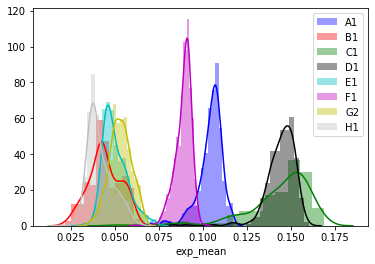

In [557]:
i=0
for s in sample_id:
    df_s = df_all.loc[df_all['sample_id'] == s]
    sns.distplot( df_s['exp_mean'] , color=colors[i], label=s)
    i=i+1

plt.legend();

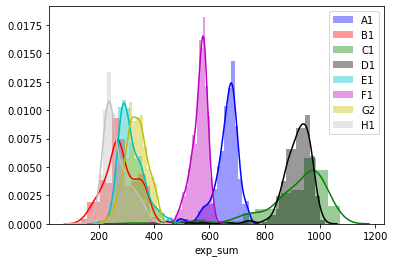

In [558]:
i=0
for s in sample_id:
    df_s = df_all.loc[df_all['sample_id'] == s]
    sns.distplot( df_s['exp_sum'] , color=colors[i], label=s)
    i=i+1

plt.legend();

It seems there's quite a variability in the expression values across samples, where some of the samples resemble each other more than other.

To understand this better, I'm also interested in seeing the distribution of a few relevant genes.

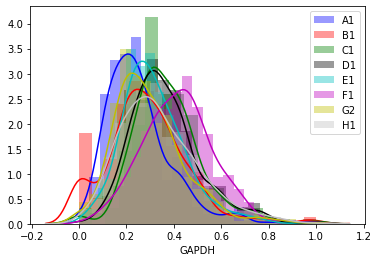

In [559]:
i=0
for s in sample_id:
    df_s = df_all.loc[df_all['sample_id'] == s]
    sns.distplot(df_s['GAPDH'] , color=colors[i], label=s)
    i=i+1
plt.legend();

*GAPDH is a classical housekeeping gene that should be roughly equally expressed across cells and samples. Based on the distribution here it looks like it has a good and equal distribution*

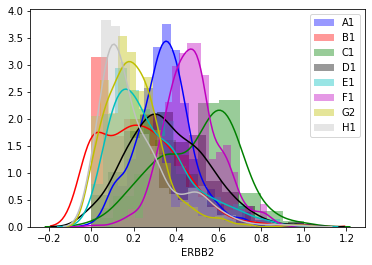

In [531]:
i=0
for s in sample_id:
    df_s = df_all.loc[df_all['sample_id'] == s]
    sns.distplot(df_s['ERBB2'] , color=colors[i], label=s)
    i=i+1
plt.legend();

*Here  is the expression of ERBB2 which encodes for HER2, a marker of certain breast cancer types*

Spatial plots

In [615]:
genes_plot = ['ERBB2', 'IGKC', 'SDC1', 'FABP4']

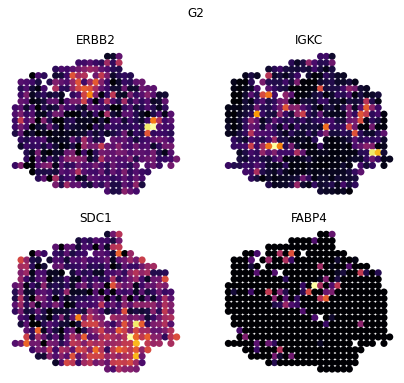

In [633]:
data_n = 6
df_plot = data_list[data_n]
n_cols=2
n_rows=2
fig,ax = plt.subplots(n_cols,
                      n_rows,
                      figsize = (3.5*n_cols, 3*n_rows))
fig.suptitle(sample_id[data_n])
ax = ax.flatten()
# plot each of the top variable genes
for k,gene in enumerate(genes_plot):
    ax[k].scatter(
        df_plot['x'],
        -df_plot['y'],
        c=df_plot[gene],
        cmap=plt.cm.inferno,
        edgecolor="w",
        linewidth=0,
        s=50
    )
    ax[k].set_title(gene)
    ax[k].axis('off');

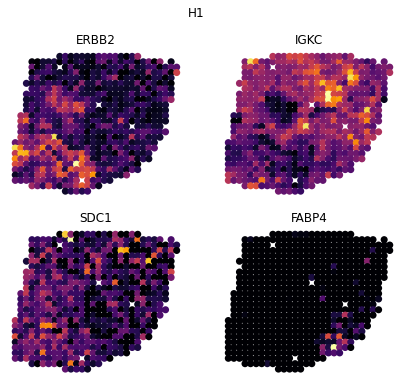

In [632]:
data_n = 7
df_plot = data_list[data_n]
n_cols=2
n_rows=2
fig,ax = plt.subplots(n_cols,
                      n_rows,
                      figsize = (3.5*n_cols, 3*n_rows))
fig.suptitle(sample_id[data_n])
ax = ax.flatten()
# plot each of the top variable genes
for k,gene in enumerate(genes_plot):
    ax[k].scatter(
        df_plot['x'],
        -df_plot['y'],
        c=df_plot[gene],
        cmap=plt.cm.inferno,
        edgecolor="w",
        linewidth=0,
        s=50
    )
    ax[k].set_title(gene)
    ax[k].axis('off');

***

### Split data into train and test

The data is now ready to be split and saved for training and testing.  
We have 8 different samples, and want to make sure we make the predictions in the end on a per sample basis, thus the split will be guided by sample id.  

To ensure enough data in the train set, I will keep 5/8 sets for train/validation and 3/8 sets for the final testing of the models.